In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
#sys.path.append('/Users/ff/dev/MSc/CX_Path_Integration')
#os.chdir('/Users/ff/dev/MSc/CX_Path_Integration/notebooks')

In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter

import cx_spiking.plotting 
import cx_spiking.inputs
import cx_spiking.optimisation.metric as metric
import cx_spiking.network_creation as nc

from cx_spiking.constants import *

In [5]:
# Constants
#N_TL2 = 16
#N_CL1 = 16
#N_TB1 = 8
#N_TN2 = 2

In [3]:
route_file = 'data/route.npz'
T_outbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=T_outbound, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)

Load route from data/route.npz
data/route.npz exists - not overwriting it


In [14]:
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                            T_outbound=T_outbound,
                                            T_inbound=0,
                                            noise=noise,
                                            cx=cx,
                                            route=(h[:T_outbound], v[:T_outbound]))

## Test same population

In [13]:
start_scope()
#defaultclock.dt = 0.05*ms

time_step = 20 # ms

recorded_spike_rates = 90 # Hz
ratio = recorded_spike_rates / (time_step * 1./1000)
print(f'ratio {ratio} - dt {defaultclock.dt}')

ratio 4500.0 - dt 0.0001


In [14]:
# transpose since log is neuron_index*time_step but we want the opposite
TL2_stimulus = TimedArray(90*log.tl2.T*Hz, dt=1.*time_step*ms)
P_TL2 = PoissonGroup(N_TL2, rates='TL2_stimulus(t,i)')
SPM_TL2_IDEAL = SpikeMonitor(P_TL2)

P_TL2_2 = PoissonGroup(N_TL2, rates='TL2_stimulus(t,i)')
SPM_TL2_2_IDEAL = SpikeMonitor(P_TL2_2)

In [15]:
%%time
run(T_outbound*time_step*ms)

CPU times: user 20 s, sys: 542 ms, total: 20.5 s
Wall time: 30.6 s


In [201]:
gf = metric.compute_gamma_factor(SPM_TL2_2_IDEAL, SPM_TL2_2_IDEAL, T_outbound*time_step*ms, 
                                 dt_=defaultclock.dt, delta=1*ms, rate_correction=True)
print(f'mean gamma factor {gf}')

mean gamma factor 2.7755575615628914e-17


## Test parameters

In [32]:
start_scope()

time_step = 20 # ms

In [33]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)', name='P_HEADING')

In [34]:
params_TL2 = neuron_params
params_TL2['tauE'] = 2.3097100050636867 * ms

synapses_TL2 = cx_spiking.constants.synapses_params
synapses_TL2['wE'] = 489.82124551680937 * nS

# Neuron group
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, params_TL2, name='TL2_source_network')

# Add monitors
STM_TL2, SPM_TL2 = nc.add_monitors(G_TL2, name='TL2_source')

# Connect heading to TL2
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, 
                                      params=synapses_TL2, on_pre=synapses_eqs_ex)

In [35]:
TL2_spike_rates = 90 # Hz

# Scale spike rates from rate-based CX in the right range
# transpose since log is neuron_index*time_step but we want the opposite
TL2_stimulus = TimedArray(TL2_spike_rates*cx_log.tl2.T*Hz, dt=1.*time_step*ms)
P_TL2 = PoissonGroup(N_TL2, rates='TL2_stimulus(t,i)', name='TL2_Poisson')
SPM_TL2_IDEAL = SpikeMonitor(P_TL2, name='TL2_target_spike_monitor')

In [36]:
run(T_outbound*time_step*ms)

In [37]:
gf = metric.compute_gamma_factor(SPM_TL2, SPM_TL2_IDEAL, T_outbound*time_step*ms, 
                                 dt_=defaultclock.dt, delta=1*ms, rate_correction=True)
print(f'mean gamma factor {gf}')

mean gamma factor 2.682814806802773


In [28]:
#params_TL2 = neuron_params
#params_TL2['tauE'] = 2.3097100050636867 * ms

#synapses_TL2 = cx_spiking.constants.synapses_params
#synapses_TL2['wE'] = 489.82124551680937 * nS

#mean gamma factor 2.594823558655974

# FROM OPTIMISER STEP -> Gamma factor: 2.7383414307876466

In [29]:
# params_TL2 = neuron_params
# params_TL2['tauE'] = 2.556891547075462 * ms

# synapses_TL2 = cx_spiking.constants.synapses_params
# synapses_TL2['wE'] = 874.8256706550628 * nS

# mean gamma factor 9.9948047683555

# FROM OPTIMISER STEP -> Gamma factor: 10.01699115016672

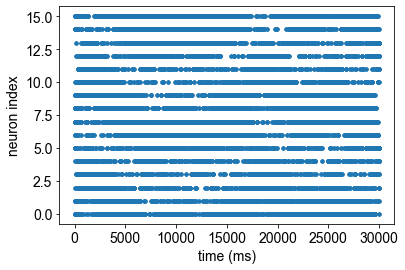

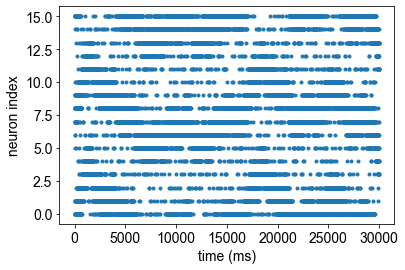

In [31]:
brian_plot(SPM_TL2)
plt.show()
brian_plot(SPM_TL2_IDEAL)

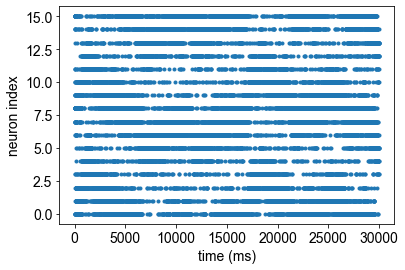

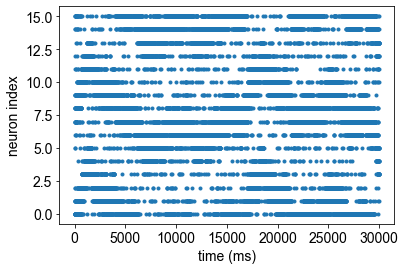

In [38]:
brian_plot(SPM_TL2)
plt.show()
brian_plot(SPM_TL2_IDEAL)

In [41]:
import nevergrad as ng

def square(x, y=12):
    return sum((x - .5)**2) + abs(y)

optimizer = ng.optimizers.OnePlusOne(instrumentation=2, budget=100)
# alternatively, you could use ng.optimizers.registry["OnePlusOne"]
# (registry is a dict containing all optimizer classes)
recommendation = optimizer.minimize(square)
print(recommendation)


Candidate(args=(array([0.5017027 , 0.49792428]),), kwargs={})
